<a href="https://colab.research.google.com/github/AlexandreBrown/AerialSemanticSegmentation/blob/main/SemanticSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic Segmentation

In [3]:
!pip install torchvision==0.9.0 torch==1.8.0 matplotlib

  Using cached matplotlib-3.4.2-cp39-cp39-manylinux1_x86_64.whl (10.3 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.1-cp39-cp39-manylinux1_x86_64.whl (1.2 MB)


# Dependencies

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pylab as plt
import numpy as np
import os
%matplotlib inline

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from os import listdir
from os.path import isfile, join
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision.datasets import ImageFolder

In [2]:
torch.manual_seed(42)

# Dataset

In [12]:
class SemanticSegmentationOnDiskDataset(Dataset):
    

  def __init__(self, images_path, masks_path, transform=None):
    self.transform = transform
    self.images_path = images_path
    self.image_file_names = [f for f in listdir(images_path) if isfile(join(images_path, f))]
    self.image_file_names.sort()
    self.masks_path = masks_path
    self.mask_files_names = [f for f in listdir(masks_path) if isfile(join(masks_path, f))]
    self.mask_files_names.sort()
    print("Directory {0} contains {1} images".format(images_path, len(self.image_file_names)))
    print("Directory {0} contains {1} images".format(masks_path, len(self.mask_files_names)))


  def __len__(self):
    return len(self.image_file_names)


  def __getitem__(self, id):

    img_file_name = self.image_file_names[id]
    img = Image.open(join(self.images_path,img_file_name))  
    
    mask_file_name = self.mask_files_names[id]
    mask = Image.open(join(self.masks_path,mask_file_name))
    
    if self.transform:
        img = self.transform(img)
        mask = self.transform(mask)
    
    return (img, mask)

# Define Visualization Utils

In [13]:
def showImagePair(img1, img2, title =""):
    f, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title(title + " Input", fontsize=20)
    ax1.imshow(img1.permute(1, 2, 0))
    ax1.figure.set_size_inches(20, 20)
    ax2.set_title(title + " Target", fontsize=20)
    ax2.imshow(img2.permute(1, 2, 0))
    ax2.figure.set_size_inches(20, 20)
    plt.tight_layout()
    plt.show()
    

# Load & Preprocess data

Directory ./dataset/train/inputs contains 320 images
Directory ./dataset/train/targets contains 320 images


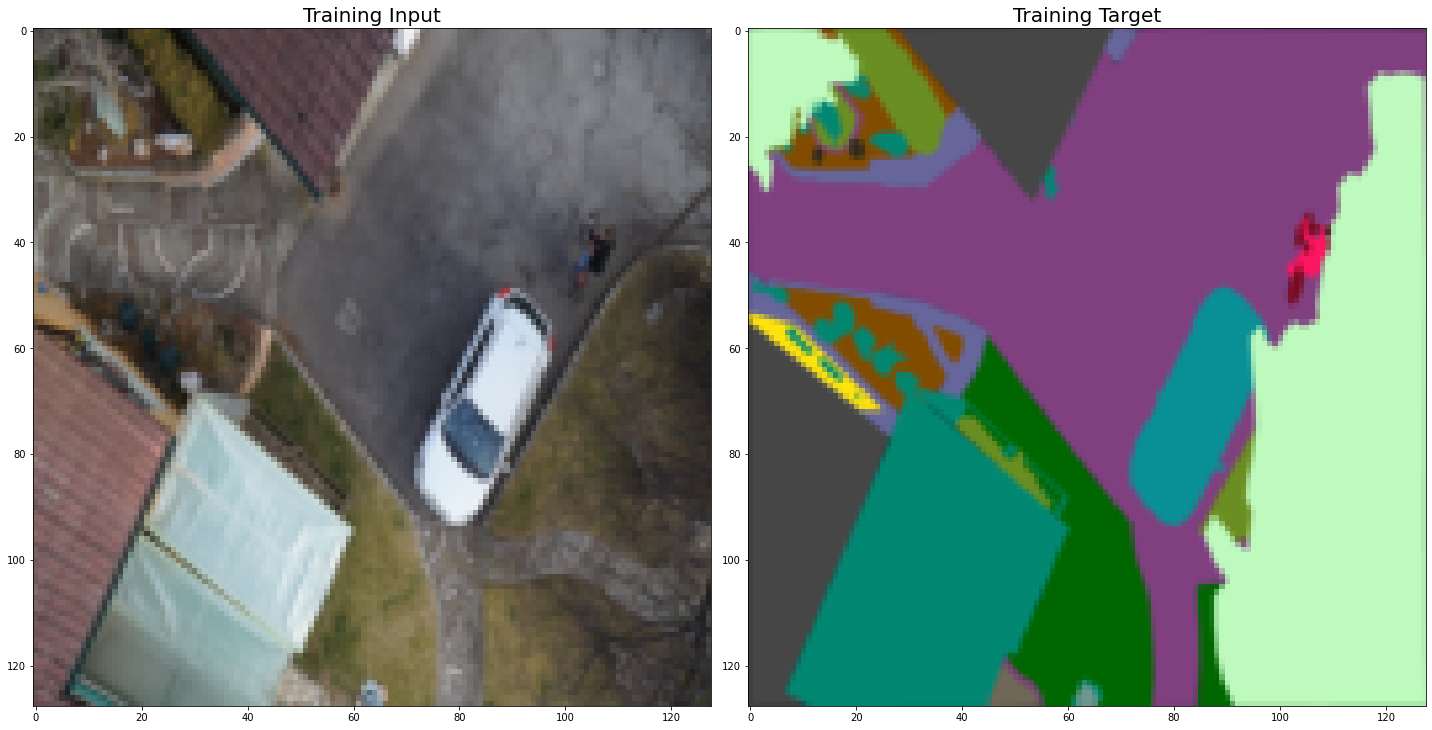

Training dataset shape : torch.Size([3, 128, 128])
Directory ./dataset/test/inputs contains 80 images
Directory ./dataset/test/targets contains 80 images


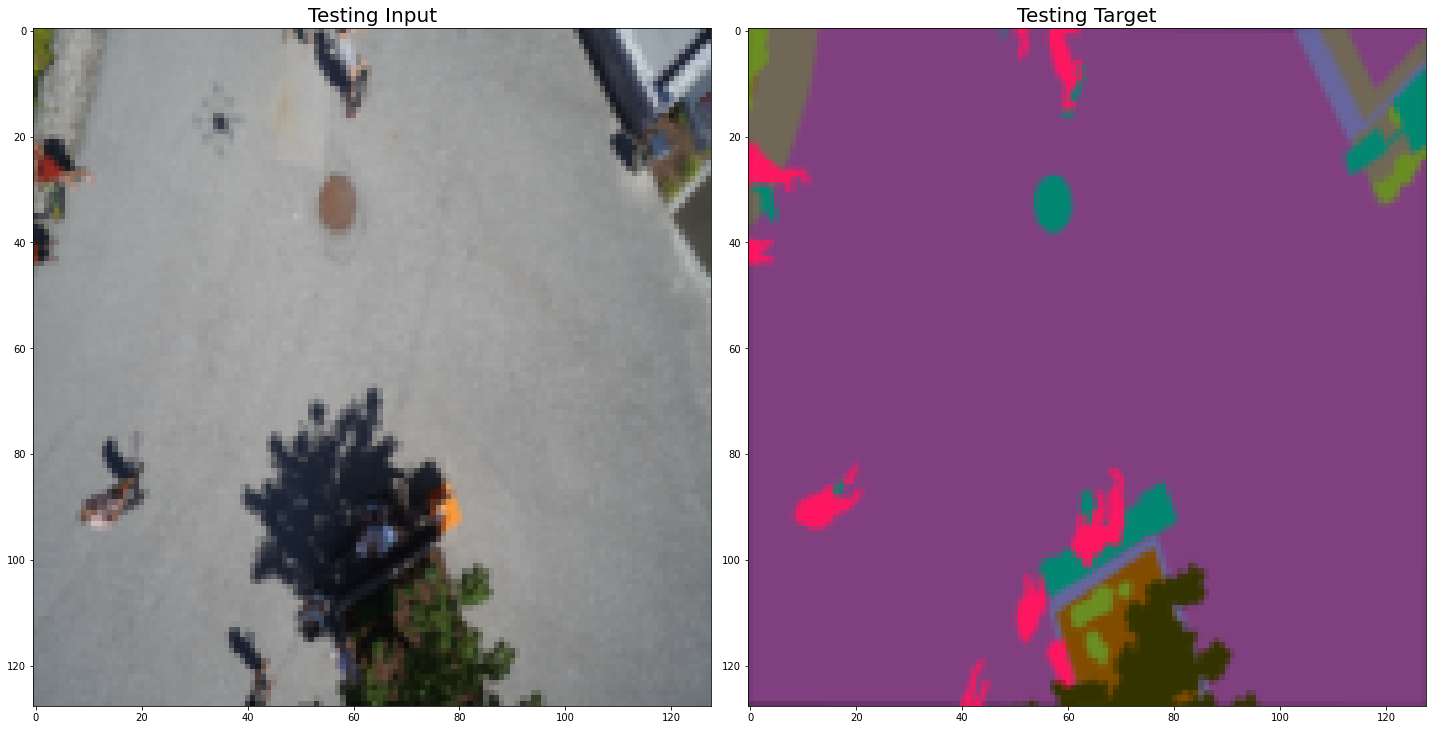

Testing dataset shape : torch.Size([3, 128, 128])


In [17]:
HEIGHT = 128
WIDTH = 128

train_path = "./dataset/train/"
train_images_path = train_path + "inputs"
train_masks_path = train_path + "targets"

train_transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)), transforms.ToTensor()])
train_dataset = SemanticSegmentationOnDiskDataset(train_images_path, train_masks_path, train_transform)
showImagePair(train_dataset[0][0], train_dataset[0][1], "Training")
print("Training dataset shape : {0}".format(train_dataset[0][0].shape))


train_path = "./dataset/test/"
test_images_path = train_path + "inputs"
test_masks_path = train_path + "targets"

test_transform = transforms.Compose([transforms.Resize((HEIGHT, WIDTH)), transforms.ToTensor()])
test_dataset = SemanticSegmentationOnDiskDataset(test_images_path, test_masks_path, test_transform)
showImagePair(test_dataset[0][0], test_dataset[0][1], "Testing")
print("Testing dataset shape : {0}".format(train_dataset[0][0].shape))

# Model

In [45]:
def get_same_padding(input_size, kernel_size, stride_size=1):
    return (input_size*stride_size - input_size - 1 + kernel_size) // 2

In [67]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    dropout = nn.Dropout(p=dropout_prob)

    conv_in_channels = inputs.shape[1]
    conv_kernel_size = 3
    conv_stride_size = 1
    same_padding_h = get_same_padding(
        input_size=inputs.shape[2], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    same_padding_w = get_same_padding(
        input_size=inputs.shape[3], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    conv = nn.Conv2d(
        in_channels=conv_in_channels, 
        out_channels=n_filters, 
        kernel_size=conv_kernel_size,
        stride=conv_stride_size,
        padding=(same_padding_h, same_padding_w)
    )(inputs)
    conv = torch.relu(dropout(conv))
    
    
    conv_in_channels = conv.shape[1]
    conv_kernel_size = 3
    conv_stride_size = 1
    same_padding_h = get_same_padding(
        input_size=conv.shape[2], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    same_padding_w = get_same_padding(
        input_size=conv.shape[3], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    conv = nn.Conv2d(
        in_channels=conv_in_channels, 
        out_channels=n_filters, 
        kernel_size=conv_kernel_size,
        stride=conv_stride_size,
        padding=(same_padding_h, same_padding_w)
    )(conv)
    conv = torch.relu(dropout(conv))

    if max_pooling:
        next_layer = nn.MaxPool2d(kernel_size=2)(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [80]:
def get_same_padding_transpose(input_size, output_size, kernel_size, stride_size=1):
    return -input_size*stride_size + stride_size - kernel_size + output_size

In [94]:
def upsampling_block(expansive_input, contractive_input, n_filters):
    
    up = nn.ConvTranspose2d(
        in_channels=expansive_input.shape[1], 
        out_channels=n_filters, 
        kernel_size=2,
        stride=2
    )(expansive_input)
    
    
    
    merge = torch.cat((up, contractive_input), dim=1)
    
    
    conv_in_channels = merge.shape[1]
    conv_kernel_size = 3
    conv_stride_size = 1
    same_padding_h = get_same_padding(
        input_size=merge.shape[2], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    same_padding_w = get_same_padding(
        input_size=merge.shape[3], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    conv = nn.Conv2d(
        in_channels=conv_in_channels, 
        out_channels=n_filters, 
        kernel_size=conv_kernel_size,
        stride=conv_stride_size,
        padding=(same_padding_h, same_padding_w)
    )(merge)
    conv = torch.relu(conv)
    
    
    conv_in_channels = conv.shape[1]
    conv_kernel_size = 3
    conv_stride_size = 1
    same_padding_h = get_same_padding(
        input_size=conv.shape[2], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    same_padding_w = get_same_padding(
        input_size=conv.shape[3], 
        kernel_size=conv_kernel_size, 
        stride_size=conv_stride_size
    )
    conv = nn.Conv2d(
        in_channels=conv_in_channels, 
        out_channels=n_filters, 
        kernel_size=conv_kernel_size,
        stride=conv_stride_size,
        padding=(same_padding_h, same_padding_w)
    )(conv)
    conv = torch.relu(conv)
    
    return conv

In [98]:
expansive_input = torch.randn(1, 256, 12, 16)
contractive_input = torch.randn(1, 128, 24, 32)
n_filters=32

upsampling_block(expansive_inputs, contractive_inputs, 32).shape

torch.Size([1, 64, 24, 32])

In [99]:
class UNet(nn.Module):
    
    def __init__(self, input_size, n_filters, n_classes):
        super(UNet, self).__init__()
        self.input_size = input_size
        self.n_filters = n_filters
        self.n_classes = n_classes
        
        
    def forward(self, x):
        cblock1, cblock1_skip = conv_block(x, self.n_filters)
        cblock2, cblock2_skip = conv_block(cblock1, self.n_filters*2)
        cblock3, cblock3_skip = conv_block(cblock2, self.n_filters*4)
        cblock4, cblock4_skip = conv_block(cblock3, self.n_filters*8, dropout_prob=0.3)
        
        cblock5, cblock5_skip = conv_block(cblock4, self.n_filters*16, dropout_prob=0.3, max_pooling=False)
        
        ublock6 = upsampling_block(expansive_input=cblock5, contractive_input=cblock4_skip,  n_filters=self.n_filters*8)
        ublock7 = upsampling_block(expansive_input=ublock6, contractive_input=cblock3_skip,  n_filters=self.n_filters*4)
        ublock8 = upsampling_block(expansive_input=ublock7, contractive_input=cblock2_skip,  n_filters=self.n_filters*2)
        ublock9 = upsampling_block(expansive_input=ublock8, contractive_input=cblock1_skip,  n_filters=self.n_filters)
        
        conv_in_channels = ublock9.shape[1]
        conv_kernel_size = 3
        conv_stride_size = 1
        same_padding_h = get_same_padding(
            input_size=ublock9.shape[2], 
            kernel_size=conv_kernel_size, 
            stride_size=conv_stride_size
        )
        same_padding_w = get_same_padding(
            input_size=ublock9.shape[3], 
            kernel_size=conv_kernel_size, 
            stride_size=conv_stride_size
        )
        conv9 = nn.Conv2d(
            in_channels=conv_in_channels, 
            out_channels=self.n_filters, 
            kernel_size=conv_kernel_size,
            stride=conv_stride_size,
            padding=(same_padding_h, same_padding_w)
        )(ublock9)
        conv9 = torch.relu(conv9)  
        
        conv10 = nn.Conv2D(filters=n_classes, kernel_size=(1,1), padding="same")(conv9)
        conv_in_channels = conv9.shape[1]
        conv_kernel_size = 1
        conv_stride_size = 1
        same_padding_h = get_same_padding(
            input_size=conv9.shape[2], 
            kernel_size=conv_kernel_size, 
            stride_size=conv_stride_size
        )
        same_padding_w = get_same_padding(
            input_size=conv9.shape[3], 
            kernel_size=conv_kernel_size, 
            stride_size=conv_stride_size
        )
        conv10 = nn.Conv2d(
            in_channels=conv_in_channels, 
            out_channels=self.n_classes, 
            kernel_size=conv_kernel_size,
            stride=conv_stride_size,
            padding=(same_padding_h, same_padding_w)
        )(conv9)
        
        return conv10

UNet()


# Training

In [103]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16)
test_loader = DataLoader(dataset=test_dataset, batch_size=10)

model = UNet((HEIGHT, WIDTH), 3, 23)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr=0.003)

for x_train, y_train in train_loader:
            z = model(x_train)
            loss = criterion(z, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(output)

ValueError: optimizer got an empty parameter list